# Toyz Ad Hoc Analysis

## Imports & Setup

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.float_format', '{:,.0f}'.format)

In [25]:
financials_df = pd.read_csv(r'C:\Users\cneva\Projects\Toy Sales\Datasets\financials.csv')
financials_df.order_date = financials_df.order_date.astype('datetime64[ns]')
bom_df = pd.read_csv(r'C:\Users\cneva\Projects\Toy Sales\Datasets\bom.csv')

In [27]:
financials_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22496 entries, 0 to 22495
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   order_date       22496 non-null  datetime64[ns]
 1   store_id         22496 non-null  object        
 2   sku              22496 non-null  object        
 3   actual_quantity  9800 non-null   float64       
 4   actual_sales     9800 non-null   float64       
 5   target_quantity  22494 non-null  float64       
 6   target_sales     22494 non-null  float64       
 7   py_quantity      22494 non-null  float64       
 8   py_sales         22494 non-null  float64       
 9   total_cost       22496 non-null  float64       
 10  actual_cost      9800 non-null   float64       
 11  py_cost          22494 non-null  float64       
 12  target_cost      22494 non-null  float64       
 13  actual_margin    9800 non-null   float64       
 14  py_margin        22494 non-null  float

## #1. Cost Increase
- Supply chain is forecasting the cost of plastic to go up 10% in Q3 and another 5% in Q4
- Calculate the impact on costs and margin at the BOM level
    - Year end total costs will go up 7% and margin will be down -31%
    - [Results](#Results)

In [29]:
# Get the date for latest actual sales
def max_actual_date():
    return \
    (financials_df[['order_date', 'actual_sales']]
    .dropna()
    .order_date
    .max()
    )

max_actual_date()

Timestamp('2024-06-01 00:00:00')

In [31]:
# Get the months to forecast on
def forecast_months():
    return \
    (financials_df
     .query("order_date > @max_actual_date()")
     .order_date.to_frame()
     .drop_duplicates()
     .reset_index(drop = True)
    )

forecast_months()

,order_date
0,2024-07-01
1,2024-08-01
2,2024-09-01
3,2024-10-01
4,2024-11-01
5,2024-12-01


In [35]:
# Increases the cost by a given percentage for dates after a specified period.
def increase_cost_after_dates(df, dates, percentages):
    if len(dates) != len(percentages):
        raise ValueError("The inputted number of dates and percentages don't match")
        
    df['new_cost'] = df['cost_ext']
    for date_str, percentage in zip(dates, percentages):
        date = pd.to_datetime(date_str)
        df.loc[(df['order_date'] >= date) & (df['material'] == 'plastic'), 'new_cost'] *= (1 + percentage / 100)
    return df

# Return a dataframe of SKU-Parts for each forecast month
def merge_parts_and_dates():
    return (pd.merge(bom_df, forecast_months(),how = 'cross'))

# Return a dataframe with new costs
new_cost_df = \
(increase_cost_after_dates(merge_parts_and_dates(), ['2024-07-01', '2024-10-01'], [10, 5])
 .groupby(['sku', 'order_date'])
 .agg(
     old_cost = ('cost_ext', 'sum'),
     new_cost = ('new_cost', 'sum')
 )
 .reset_index()
)

new_cost_df

,sku,order_date,old_cost,new_cost
0,A100,2024-07-01,30,33
1,A100,2024-08-01,30,33
2,A100,2024-09-01,30,33
3,A100,2024-10-01,30,35
4,A100,2024-11-01,30,35
...,...,...,...,...
145,C102,2024-08-01,21,21
146,C102,2024-09-01,21,21
147,C102,2024-10-01,21,22
148,C102,2024-11-01,21,22


In [37]:

fc_df = \
(financials_df
 .query("order_date > @max_actual_date()")
 .merge(new_cost_df)
 .assign(
     old_cost_ext = lambda df: df.target_quantity * df.old_cost,
     new_cost_ext = lambda df: df.target_quantity * df.new_cost,
     old_margin = lambda df: df.target_sales - df.old_cost_ext,
     new_margin = lambda df: df.target_sales - df.new_cost_ext,
 )
 .groupby('order_date')
 .agg(
     cost = ('old_cost_ext', 'sum'),
     new_cost = ('new_cost_ext', 'sum'),
     margin = ('old_margin', 'sum'),
     new_margin = ('new_margin', 'sum')
 )
)
fc_df

,cost,new_cost,margin,new_margin
order_date,,,,
2024-07-01,"20,707,980","21,907,005","4,981,198","3,782,174"
2024-08-01,"20,904,883","22,105,347","4,957,436","3,756,971"
2024-09-01,"19,822,108","20,966,380","4,722,321","3,578,048"
2024-10-01,"20,993,376","22,863,712","5,002,691","3,132,356"
2024-11-01,"20,160,221","21,954,920","4,753,256","2,958,556"
2024-12-01,"20,731,581","22,567,577","4,935,573","3,099,577"


### Results

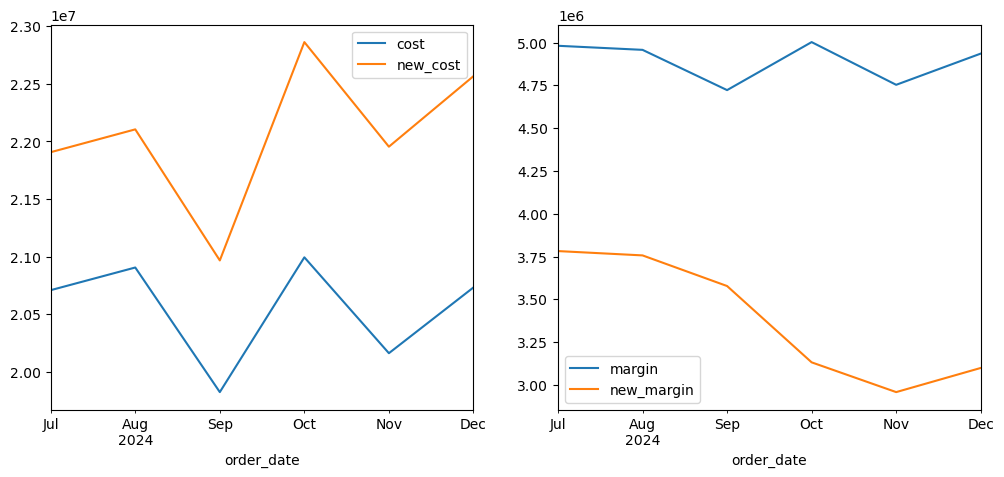

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
fc_df[['cost','new_cost']].plot(ax = ax[0])
fc_df[['margin','new_margin']].plot(ax = ax[1])
plt.show()

In [43]:
def result_cost():
    return \
    (fc_df[['cost','new_cost']]
     .sum()
     .to_frame().T
     .rename(columns = {'cost': 'original', 'new_cost': 'new'})
     .assign(
         diff = lambda df: df['new'] - df['original'],
         perc_change=lambda df: (df['diff'] / df['original'] * 100).map(lambda x: f"{x:.1f}%")
    
     )
     .T.rename(columns = {0: 'cost'})
    )

def result_margin():
    return \
    (fc_df[['margin','new_margin']]
     .sum()
     .to_frame().T
     .rename(columns = {'margin': 'original', 'new_margin': 'new'})
     .assign(
         diff = lambda df: df['new'] - df['original'],
         perc_change=lambda df: (df['diff'] / df['original'] * 100).map(lambda x: f"{x:.1f}%")
    
     )
     .T.rename(columns = {0: 'margin'})
    )

def results():
    return \
    pd.concat([result_cost(), result_margin()], axis = 1)

results()

,cost,margin
original,"123,320,148","29,352,476"
new,"132,364,941","20,307,683"
diff,"9,044,793","-9,044,793"
perc_change,7.3%,-30.8%
